## Import common packages

In [1]:
import pandas as pd
import numpy as np
import nltk

## Load Cleaned Data Set

In [2]:
cleanDF = pd.read_csv("C:\git\CSML1010-Group_11-Final-Project\proposal\Tweets_cleaned.csv") 
cleanDF.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'text',
       'text_cleaned', 'emojis_flag', 'emojis', 'emoticons_flag', 'emoticons',
       'text_cleaned_without_emojis_emoticons', 'hashtags',
       'text_cleaned_without_emojis_emoticons_hashtags', 'hashtags_flag',
       'text_cleaned_lower_case', 'text_cleaned_no_abbreviations',
       'text_list_no_stop_words', 'lemmas_list'],
      dtype='object')

## Bag of Words Model

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(cleanDF['lemmas_list'].values.astype('U'))
#.values.astype('U') converts the column of words to a unicode string
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [4]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

#pd.options.display.max_columns = 100
#pd.set_option('display.max_rows', 100)

#pd.DataFrame(cv_matrix, columns=vocab).to_csv("bagofwords.csv")

## Bag of N-Grams

In [5]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(cleanDF['lemmas_list'].values.astype('U'))

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)

#pd.DataFrame(bv_matrix, columns=vocab).to_csv("bagofngrams.csv")

## TF-IDF Model

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(cleanDF['lemmas_list'].values.astype('U'))
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

pd.DataFrame(np.round(tv_matrix, 2), columns=vocab).to_csv("tfidfmodel.csv")

## Cosine Document Similarity

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

similarity_df.to_csv("documentsimilarity.csv")

## Word2Vec Word Embedding Model
### Training with CBOW (Continuous Bag of Words)

#### Build Vocabulary

In [3]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(cleanDF['lemmas_list'].values.astype('U'))
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in cleanDF['lemmas_list'].values.astype('U')]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.


Vocabulary Size: 8872
Vocabulary Sample: [('flight', 1), ('thank', 2), ('hour', 3), ('cancel', 4), ('service', 5), ('time', 6), ('delay', 7), ('customer', 8), ('help', 9), ('get', 10)]


#### Build (context_words, target_word) pair generator

In [4]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [5]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['plus', 'add', 'experience', 'tacky'] -> Target (Y): commercial
Context (X): ['aggressive', 'blast', 'entertainment', 'guest'] -> Target (Y): obnoxious
Context (X): ['blast', 'obnoxious', 'guest', 'face'] -> Target (Y): entertainment
Context (X): ['obnoxious', 'entertainment', 'face', 'little'] -> Target (Y): guest
Context (X): ['entertainment', 'guest', 'little', 'recourse'] -> Target (Y): face
Context (X): ['seriously', 'pay', 'seat', 'playing'] -> Target (Y): flight
Context (X): ['pay', 'flight', 'playing', 'bad'] -> Target (Y): seat
Context (X): ['flight', 'seat', 'bad', 'thing'] -> Target (Y): playing
Context (X): ['seat', 'playing', 'thing', 'fly'] -> Target (Y): bad
Context (X): ['playing', 'bad', 'fly', 'va'] -> Target (Y): thing
Context (X): ['yes', 'nearly', 'fly', 'vx'] -> Target (Y): time


#### Build CBOW Deep Network Model

In [6]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

import tensorflow as tf
with tf.device('/gpu:0'):
    
    cbow = Sequential()
    cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
    cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
    cbow.add(Dense(vocab_size, activation='softmax'))

    cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    print(cbow.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            887200    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8872)              896072    
Total params: 1,783,272
Trainable params: 1,783,272
Non-trainable params: 0
_________________________________________________________________
None


##### Visualize Model

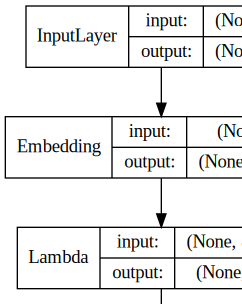

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

#### Train model for 5 epochs

In [ ]:
with tf.device('/gpu:0'):
    for epoch in range(1, 6):
        loss = 0.
        i = 0
        for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
            i += 1
            loss += cbow.train_on_batch(x, y)
            if i % 100000 == 0:
                print('Processed {} (context, word) pairs'.format(i))

        print('Epoch:', epoch, '\tLoss:', loss)
        print()

C:\ProgramData\Anaconda3\envs\milestone1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Processed 100000 (context, word) pairs
Epoch: 1 	Loss: 980699.2105463557

Processed 100000 (context, word) pairs
Epoch: 2 	Loss: 1144282.866285345

Processed 100000 (context, word) pairs
Epoch: 3 	Loss: 1337395.7755461363

Processed 100000 (context, word) pairs
Epoch: 4 	Loss: 1453879.772978104



#### Get word embeddings

In [ ]:

weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

word2vecCBOWtrained = pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

#pd.DataFrame(weights, index=list(id2word.values())[1:]).to_csv("word2vecCBOWtrained.csv")

#### Build a distance matrix to view the most similar words (contextually)¶

In [ ]:
#load word embeddings (COMMENT OUT BELOW if re-training)
word2vecCBOWtrained = pd.read_csv("word2vecCBOWtrained.csv") 

from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(cleanDF)
print(distance_matrix.shape)

# view contextually similar words
similar_words_CBOW = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['flight', 'airline', 'good', 'bad', 'time', 'seat', 'amazing', 'experience']}

similar_words_CBOW

#### Visualize word embeddings

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words_CBOW.items()], [])
wvs = word2vecCBOWtrained.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Word2Vec Word Embedding Model
### Training with Skip-Gram

## Word2Vec Word Embedding Model
### Using gensim to train model

In [4]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in (cleanDF['lemmas_list'].values.astype('U'))]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['flight', 'airline', 'good', 'bad', 'time', 'seat', 'amazing', 'experience']}
similar_words

{'flight': ['swrr', 'fvf9yw', 'afternoon', 'versace', 'bicep'],
 'airline': ['investment', 'saddening', 'absolute', 'business', 'faithful'],
 'good': ['appleton', 'well', 'kate', 'surprised', 'favorite'],
 'bad': ['horrible', 'terrible', 'awful', 'difficulty', 'unpleasant'],
 'late': ['2hr30min', 'stuck', 'hilo', '8hrs', 'aaaand'],
 'seat': ['economy', 'seating', 'leg', 'row', 'scoot'],
 'amazing': ['fantastic', 'miracle', '👍', 'cali', 'awesome'],
 'experience': ['confrontational',
  'officially',
  'irresponsible',
  'unsympathetic',
  'exp']}

In [5]:
import gensim

#export model
w2v_model.wv.save_word2vec_format(fname='gensim_word2vec_trained.bin', binary=True)

#### Visualize word embeddings

C:\ProgramData\Anaconda3\envs\milestone1\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\milestone1\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 56397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\milestone1\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 128077 missing from current font.
  font.load_char(ord(s), flags=flags)


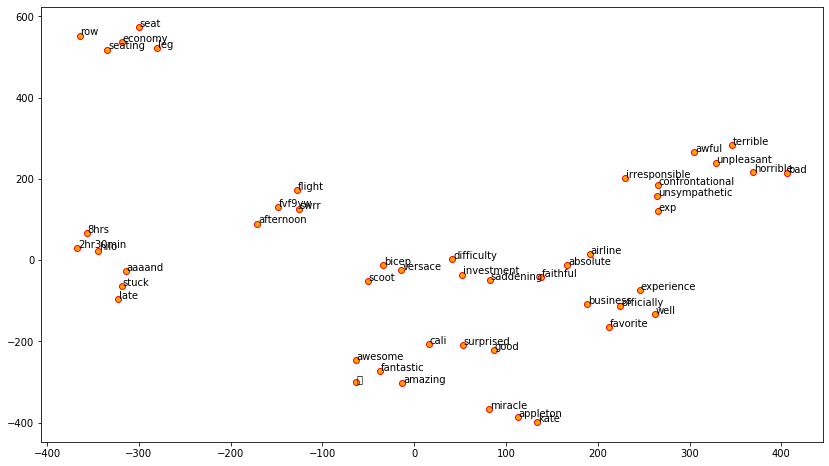

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Word2Vec Word Embedding Model
### Using Pre-Trained Model from Google
##### Subet of Google's word2vec model for the 500,000 most frequent words

In [3]:
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format(r'C:\Users\Patrick\gensim-data\word2vec-google-news-300\word2vec-google-news-300\GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['flight', 'airline', 'good', 'bad', 'time', 'seat', 'amazing', 'experience']}
similar_words

C:\ProgramData\Anaconda3\envs\milestone1\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


{'flight': ['flights', 'plane', 'Flight', 'airplane', 'takeoff'],
 'airline': ['airlines', 'Airlines', 'Airline', 'Airways', 'Lufthansa'],
 'good': ['great', 'bad', 'terrific', 'decent', 'nice'],
 'bad': ['good', 'terrible', 'horrible', 'Bad', 'lousy'],
 'time': ['day', 'moment', 'days', 'period', 'periods'],
 'seat': ['seats', 'Seat', 'Seats', 'seat_vacated', 'seated'],
 'amazing': ['incredible',
  'awesome',
  'unbelievable',
  'fantastic',
  'phenomenal'],
 'experience': ['experiences',
  'expertise',
  'expereince',
  'experince',
  'knowledge']}

In [5]:
from gensim.models import KeyedVectors

#export model
w2v_model.wv.save_word2vec_format(fname='gensim_word2vec_google_subset.bin', binary=True)

C:\ProgramData\Anaconda3\envs\milestone1\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


C:\ProgramData\Anaconda3\envs\milestone1\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


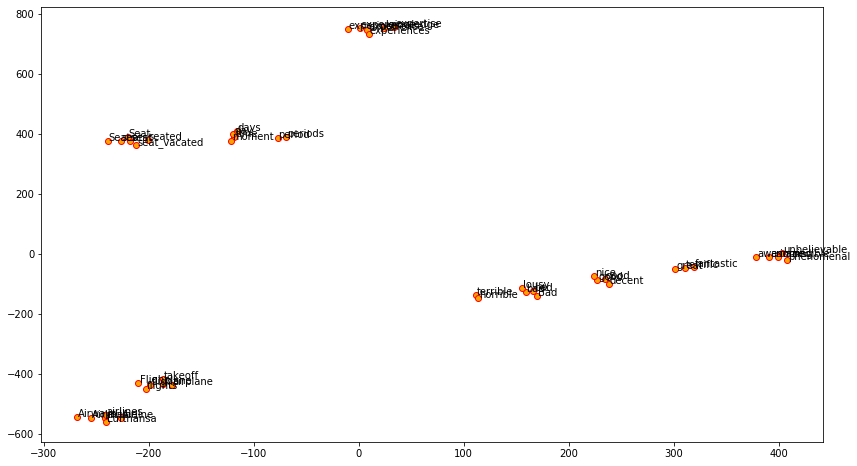

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# General Testing

In [ ]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")